In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/thesisrc.py')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from scipy import ndimage 
from skimage import io, img_as_float
from skimage.transform import rotate

import pickle
import os, glob, shutil, random

In [2]:
img_dir = '/Users/nik/Dropbox/cnt_filter/original'
test_dir = '/Users/nik/Dropbox/cnt_filter/test'
fig_dir = '/Users/nik/Dropbox/Repos/thesis/figures/chapter3'
os.chdir(test_dir)

In [3]:
# get the filelist
filelist = pickle.load( open( "filelist.p", "rb" ) )
tlist = [filelist[i] for i in [3,11,13,16,20]] # subset of filelist to test

In [4]:
# get the image arrays
NY = 768; NX = 1024
imarray = np.zeros((len(tlist),NY,NX))
for i, t in enumerate(tlist):
    imarray[i] = img_as_float(ndimage.imread(tlist[i]))

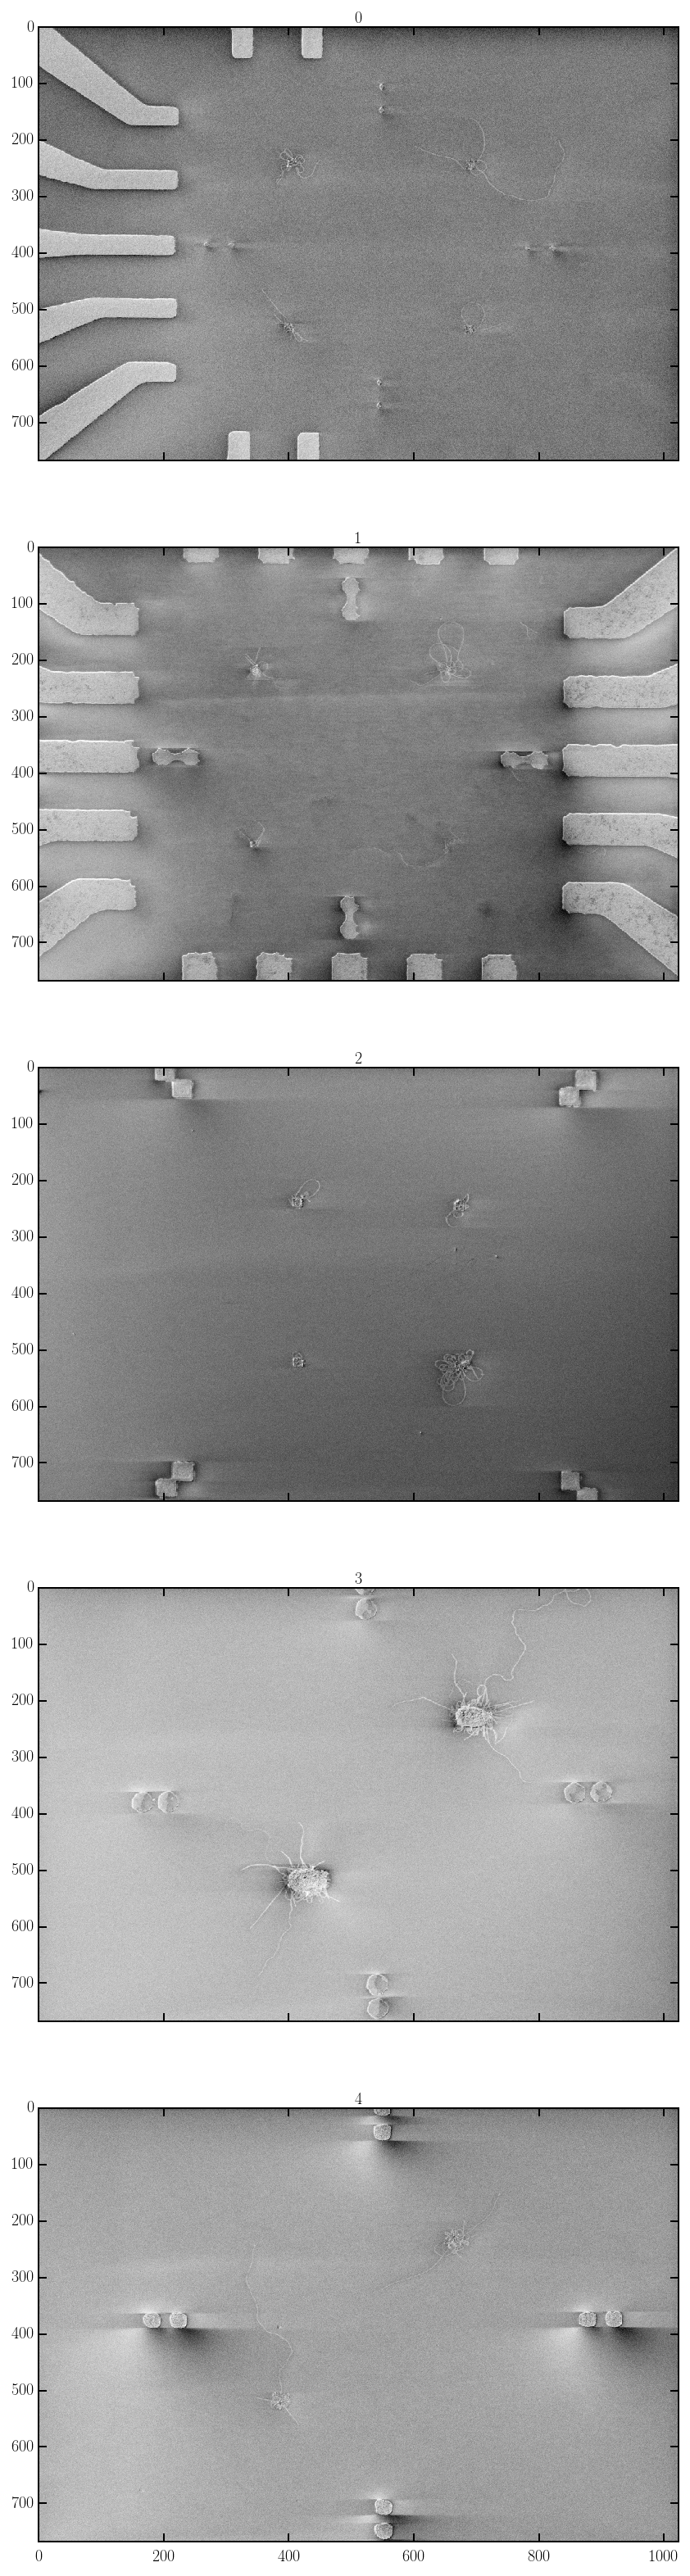

In [5]:
# Here are the unedited images
fig, axs = plt.subplots(5,1,sharex = True, sharey=False, 
                        figsize=(1*14,5*11))
axs = axs.flat

for i, im in enumerate(imarray):
    axs[i].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
    axs[i].set_title(i)

In [6]:
# all of the functions I need to create the filter

def sinc(x, k, a):
    """ return a sinc function cutoff at +/-2*pi/a """
    
    iz = int(len(x)/2)
    il = iz-np.ceil(2.0*np.pi/k)
    iu = iz+np.ceil(2.0*np.pi/k)+1
    
    s = np.sin(k*x)/(k*x) # function to start with
    s[iz] = 1 # numpy doesn't know about limits
    s[il:iu] -= s[il:iu].mean()
    s[0:il] = 0; s[iu:] = 0
    return a*s

def build_kernel(k, a, L, N):
    """ N is an odd integer. The kernel will be size NxN with (x,y) = (0,0)
        in the center. """
    x = np.arange(-(N/2),(N/2)+1,1)
    kernel = np.zeros((N,N), dtype = np.float)
    kernel[abs(x)<L/2.0, :] = sinc(x, k, a)
    return kernel

def build_filter_bank(k, a, L, N, R):
    """ builds the nanotube filter bank 
            k -- inverse length for sinc function
            a -- height of sinc function
            L -- nanotube length to search for
            N -- size of filter matrix
            R -- number of rotations """
    
    rotations = rotations = np.linspace(0,180,R+1)[:-1]

    fbank = np.zeros((len(rotations),N,N))
    kernel = build_kernel(k, a, L, N)
    for i, r in enumerate(rotations):
        fbank[i] = ndimage.rotate(kernel, r, reshape=False, mode='nearest')
    return fbank

def apply_filter(im, fbank, threshold):
    """ apply the bank of filters to a given image """

    result = np.zeros(im.shape)
    for i, f in enumerate(fbank):
        imfilt = ndimage.convolve(im, fbank[i], mode='nearest')
        result += imfilt>threshold
    return result

class ImgFilter(object):

    def __init__(self, k, a, L, N, R, threshold):
        self.k = k
        self.a = a
        self.L = L
        self.N = N
        self.R = R
        self.threshold = threshold
        self.bank = build_filter_bank(self.k, self.a, self.L, self.N, self.R)
    def __call__(self, im):
        return apply_filter(im, self.bank, self.threshold)

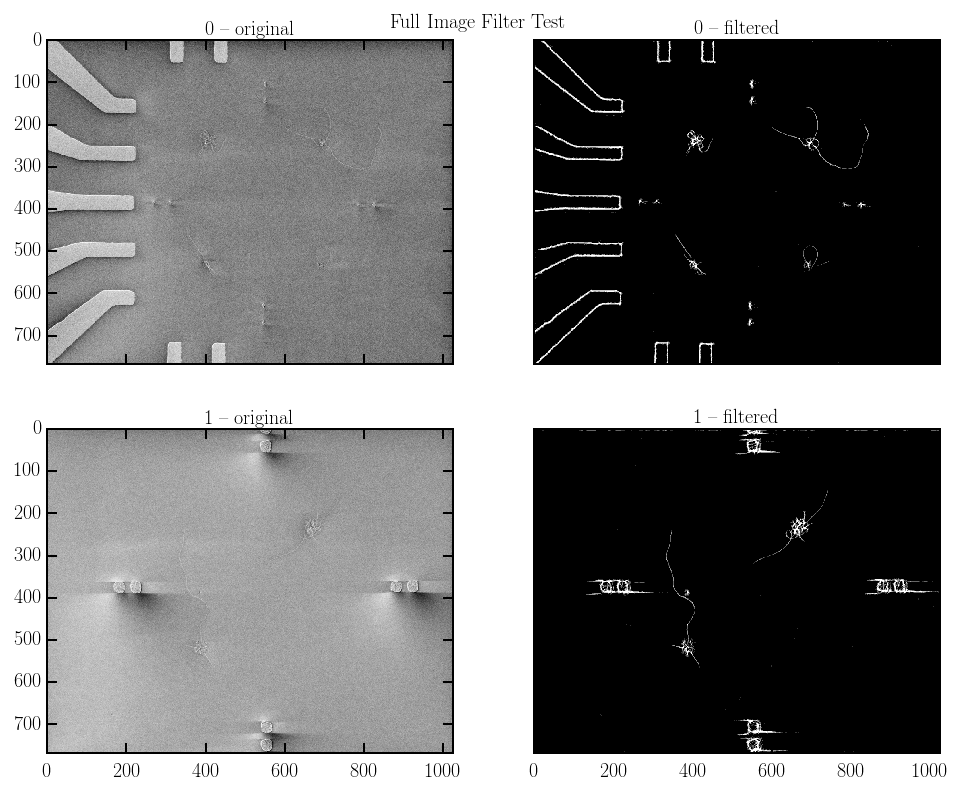

In [9]:
# initial variables
k = 1.75
a = 10.0
L = 16.0
N = 25
R = 15
threshold = 3.6

mfilter = ImgFilter(k, a, L, N, R, threshold)

fig, axs = plt.subplots(2,2,sharex = True, sharey=True, 
                       figsize=(2*8,2*6))

imsubset = np.array([imarray[0], imarray[4]])
# imsubset = imarray

imfiltered = np.zeros(imsubset.shape)
for i, im in enumerate(imsubset):
    for j in range(2):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{0} -- original'.format(i))
        else:
            imfiltered[i] = mfilter(im)
            axs[i, j].imshow(imfiltered[i], cmap = plt.cm.gray, vmin=0, vmax=5,
                             aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{0} -- filtered'.format(i))
            
fig.suptitle('Full Image Filter Test')
fig.subplots_adjust(top=0.95)
fig.savefig(os.path.join(fig_dir,'full_image_filter_test.pdf'), format='pdf', dpi=300)

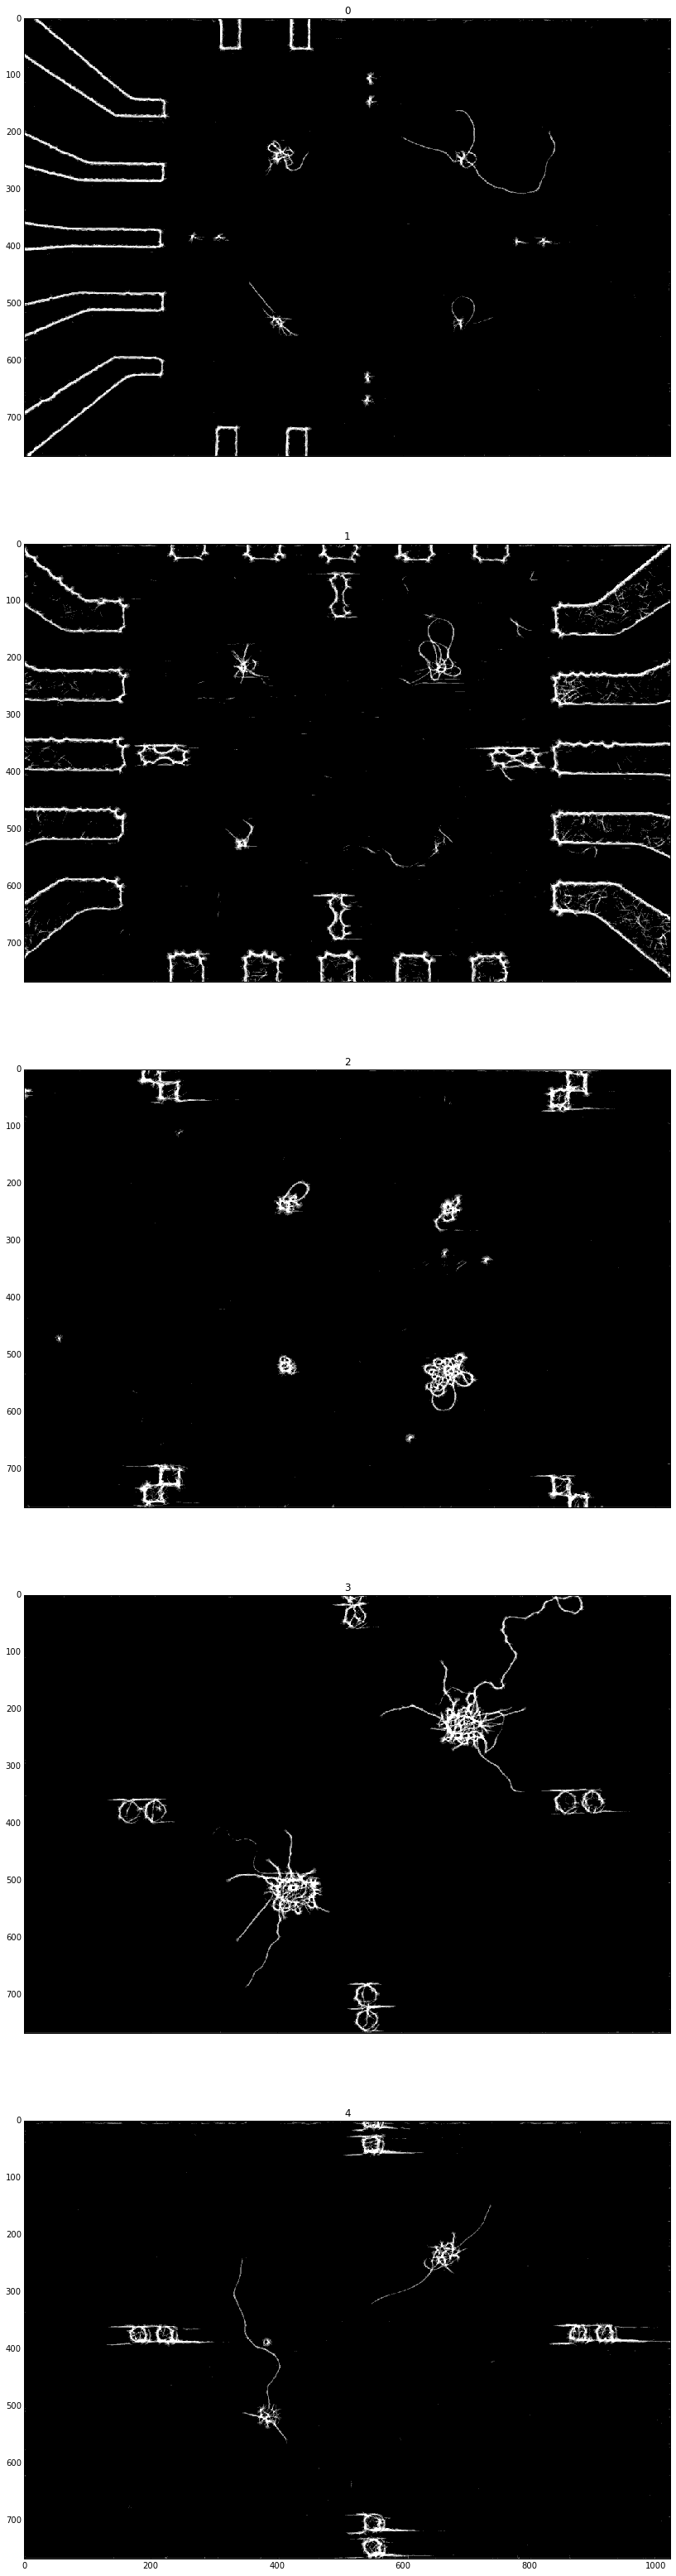

In [47]:
fig, axs = plt.subplots(5,1,sharex = True, sharey=False, 
                        figsize=(1*14,5*11))
axs = axs.flat

for i, imfilt in enumerate(imfiltered):
    axs[i].imshow(imfilt, cmap = plt.cm.gray, vmin=0, vmax=5,
                  aspect = 'auto', interpolation = 'None')
    axs[i].set_title(i)

In [152]:
# let's see what comes out of ndimage.label
im = imfiltered[0] # this is the image i'm going to mess with

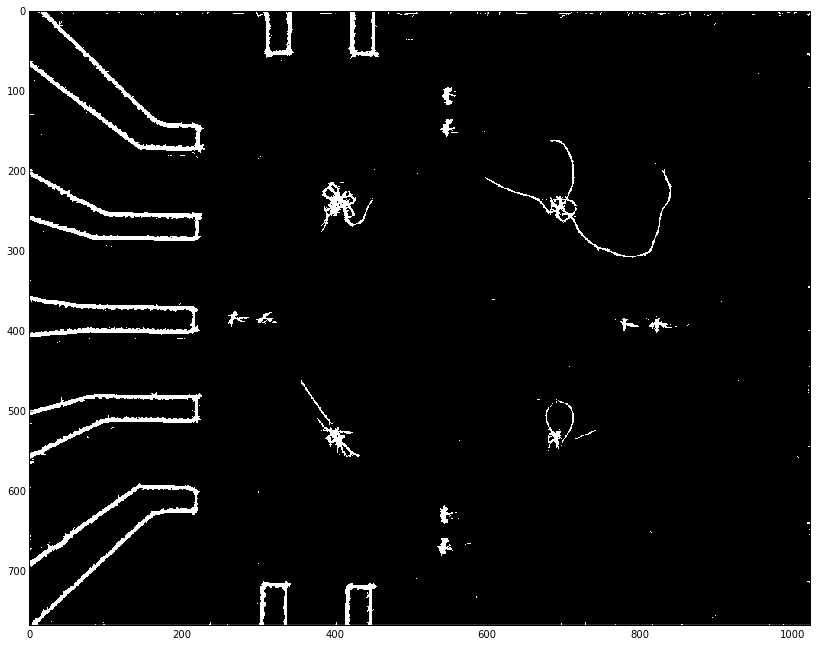

In [178]:
# maybe some additional filtering is in order?
from skimage.morphology import disk

bim = im>=1 # this is the binary verion of my filtered image
fig = plt.figure(figsize=(14,11))
ax = fig.add_subplot(1,1,1)
axim = ax.imshow(bim, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')